# Proyecto Final: Parte 3 - Clasificación con Tópicos
- ***Materia:*** Análisis Inteligente de Textos
- ***Maestro:*** Octavio Augusto Sánchez Velázquez
- ***Alumno:*** José Antonio Velázquez Sánchez

In [21]:
import pickle
import myutils
import time
import numpy as np
from gensim import corpora, models
import gensim.matutils

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Para desactivar algunos warnings de Scikit

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Objetivo
- El objetivo de este cuaderno es continuar con el trabajo realizado en el cuaderno anterior pero ahora de una manera automatizada para obtener los mejores parámetros para obtener tópicos que ayuden a clasificar a una película por su género.

# Cargando Datos

Se cargan los datos obtenidos en cuadernos pasados.

In [2]:
txts_spa = pickle.load(open("./pickles/txts_spa.pickle", "rb"))
dictionary_spa = corpora.Dictionary.load("./pickles/dictionary_spa.dict")
frecs_spa = pickle.load(open("./pickles/frecs_spa.pickle", "rb"))

txts_eng = pickle.load(open("./pickles/txts_eng.pickle", "rb"))
dictionary_eng = corpora.Dictionary.load("./pickles/dictionary_eng.dict")
frecs_eng = pickle.load(open("./pickles/frecs_eng.pickle", "rb"))

txts_fre = pickle.load(open("./pickles/txts_fre.pickle", "rb"))
dictionary_fre = corpora.Dictionary.load("./pickles/dictionary_fre.dict")
frecs_fre = pickle.load(open("./pickles/frecs_fre.pickle", "rb"))

movieids = pickle.load(open("./pickles/movieids.pickle", "rb"))
titulos = pickle.load(open("./pickles/titulos.pickle", "rb"))

Se separan los datos en conjuntos de entrenamiento y de prueba

In [3]:
train_txts_spa, train_labels_spa, test_txts_spa, test_labels_spa = myutils.split_training_txts(txts_spa, training_ratio = .85)
train_txts_eng, train_labels_eng, test_txts_eng, test_labels_eng = myutils.split_training_txts(txts_eng, training_ratio = .85)
train_txts_fre, train_labels_fre, test_txts_fre, test_labels_fre = myutils.split_training_txts(txts_fre, training_ratio = .85)

# Encontrando los mejores parámetros para Random Forests

En el cuaderno anterior mi objetivo era explorar manualmente cómo variaban los tópicos al cambiar los parámetros de LDA, y al final plotée una simple proyección en 2D de los documentos según los modelos obtenidos de LDA.

Sin embargo, el objetivo del proyecto es clasificar películas en géneros a partir de sus subtítulos, así que debo de tomar este objetivo para poder escoger los mejores parámetros de LDA.

Tras ver los plots del cuaderno pasado, siento que para ciertos parámetros de LDA los datos sí son visiblemente separables. Debido a esto, creo que un clasificador básico podría conseguir el objetivo del proyecto.

El clasificador que he decidido utilizar es el de Random Forest, ya que es sumamente rápido de entrenar, y en el pasado me ha dado buenos resultados en las asignaturas de otras clases.

Es así que en esta sección entrenaré distintos modelos de LDA utilizando distintos parámetros y escogeré los parámetros que mejor funcionen para el Random Forest al ser evaluado sobre el conjunto de datos de prueba (el cual no participará ni en la obtención de los tópicos ni en el entrenamiento del clasificador).

Sin embargo, debido a lo tardado del entrenamiento del LDA, y ha que son muchos los parámetros que pueden ser variados, he tenido que reducir el número de passes a solo 3 pero preservando 400 iteraciones. Esta decisión está basada en mi experiencia con el cuaderno pasado, donde un mayor número de iteraciones mejoraba considerablemente la convergencia indicada en los logs, y el hecho de que se alcanzaba a las pocas passes.

Así mismo, solamente contemplo 3 parámetros a variar:
- Número de tópicos: considero 25, 100 y 250
- El número aproximado de stopwords a considerar (usando el mismo método que en el cuaderno anterior) de 100, 300 y 1000)
- El tamaño del chunk_size con el cual segmentar el corpus. Consideré tamaños de 100, 200 y 500

En todos los casos el overlap_size es de la mitad del tamaño del chunk_size, y se hacen las 3 passes con 400 iteraciones ya mencionadas.

Además, hago el proceso anterior solamente tomando al corpus en español. La idea es encontrar los mejores parámetros, y esperar que también funcionen en las otras lenguas.

Para cada modelo entrenado grafico cómo lucen los documentos (las películas) tras obtener sus representaciones vectoriales según el modelo de LDA y proyectarlas en 2D usando PCA, y al igual que en el cuaderno pasado utilizo colores para identificar los géneros de las películas (rojo para acción, verde para romance/comedia y azúl para horror).

In [4]:
def train_model(txts, dictionary, frecs, n_topics, n_stw, chunk_size, overlap_size, passes = 15, iterations = 400):
    stopwords = myutils.intersect_most_common(frecs, n = n_stw)
    corpus = myutils.texts2lists(txts, stopwords = stopwords)
    corpus = myutils.split_lists(corpus, chunk_size = chunk_size, overlap_size = overlap_size)
    corpus = myutils.lists2bow(corpus, dictionary)

    model = models.LdaModel(corpus, id2word=dictionary, \
                                  num_topics=n_topics, passes = passes, iterations = iterations)
    
    return model

def transform_documents(txts, dictionary, frecs, model, n_topics, n_stw):
    """
    Transforma una lista de strings "txts" a una lista de vectores bow X
    """
    if n_stw == 0:
        stopwords = []
    else:
        stopwords = myutils.intersect_most_common(frecs, n = n_stw)

    corpus = myutils.texts2lists(txts, stopwords = stopwords)
    corpus = myutils.lists2bow(corpus, dictionary)
        
    corpus = [model.get_document_topics(doc) for doc in corpus]
    X = gensim.matutils.corpus2dense(corpus, num_terms=n_topics).T
    return X

In [115]:
def plot_results(X, txts_colors, ax, n_topics, n_stw, chunk_size, accuracy, ellapsed):
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)
    
    titulo = "Tópicos: {0}, Stopwords: {1}, Chunk_size: {2}\nTime: {4:.2f}, Accuracy: {3:.4f}"\
        .format(n_topics, n_stw, chunk_size, accuracy, ellapsed)

    ax.scatter(X[:,0], X[:,1], marker='o', c = txts_colors)
    ax.set_title(titulo)

In [116]:
def run_experiments(train_txts, test_txts, train_labels, test_labels,
                   dictionary, frecs, n_topics, passes = 3, iterations = 400):

    txts_colors = myutils.index2color(train_labels + test_labels, ['red', 'green', 'blue'])
    
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharey=True, figsize=(15,15))
    axs = [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]]

    for i, n_stw in enumerate([100, 300, 1000]):
        for j, chunk_size in enumerate([100, 200, 500]):
            inicio = time.time()
            model = train_model(train_txts, dictionary, frecs, \
                        n_topics = n_topics, n_stw = n_stw, \
                        chunk_size = chunk_size, overlap_size = int(chunk_size/2),
                               passes = passes, iterations = iterations)

            X_train = transform_documents(train_txts, dictionary, frecs,
                   model = model, n_topics = n_topics, n_stw = n_stw)

            X_test = transform_documents(test_txts, dictionary, frecs,
                   model = model, n_topics = n_topics, n_stw = n_stw)

            clf = RandomForestClassifier()
            clf.fit(X_train, train_labels)
            accuracy = clf.score(X_test, test_labels)
            ellapsed = (time.time() - inicio)/60

            plot_results(np.vstack([X_train, X_test]), txts_colors, axs[i][j], n_topics, n_stw, chunk_size, accuracy, ellapsed)
            
    plt.show()

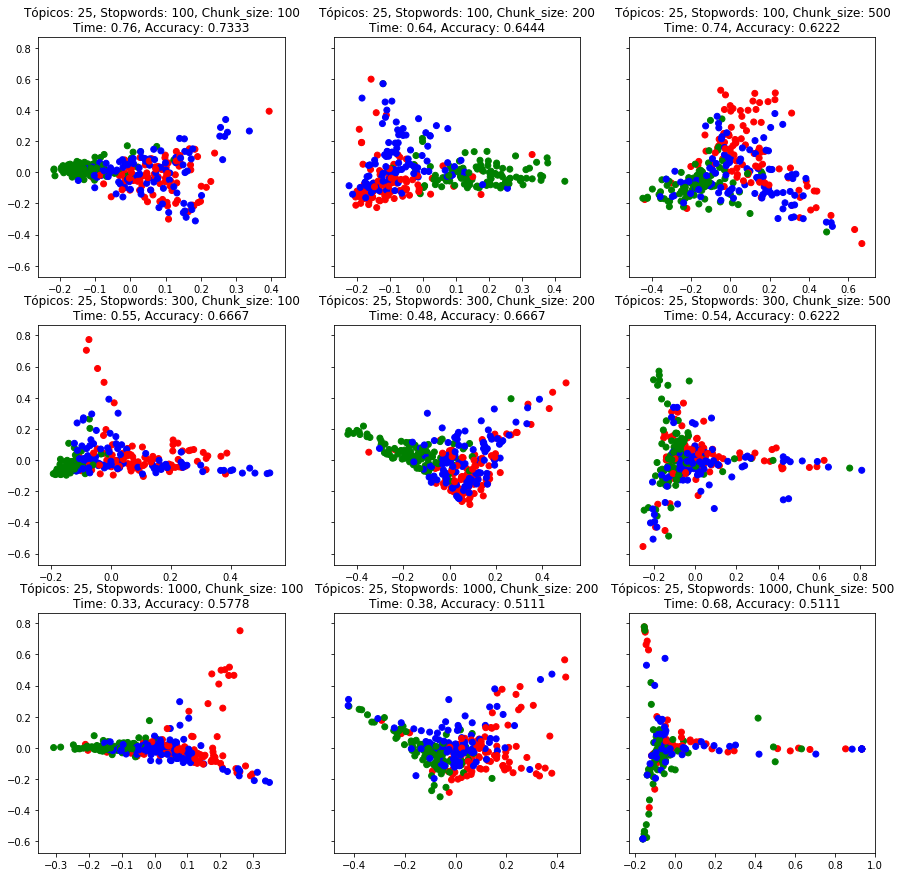

In [117]:
run_experiments(train_txts_spa, test_txts_spa, train_labels_spa, test_labels_spa,
                dictionary_spa, frecs_spa,
                n_topics = 25
               )

/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  di

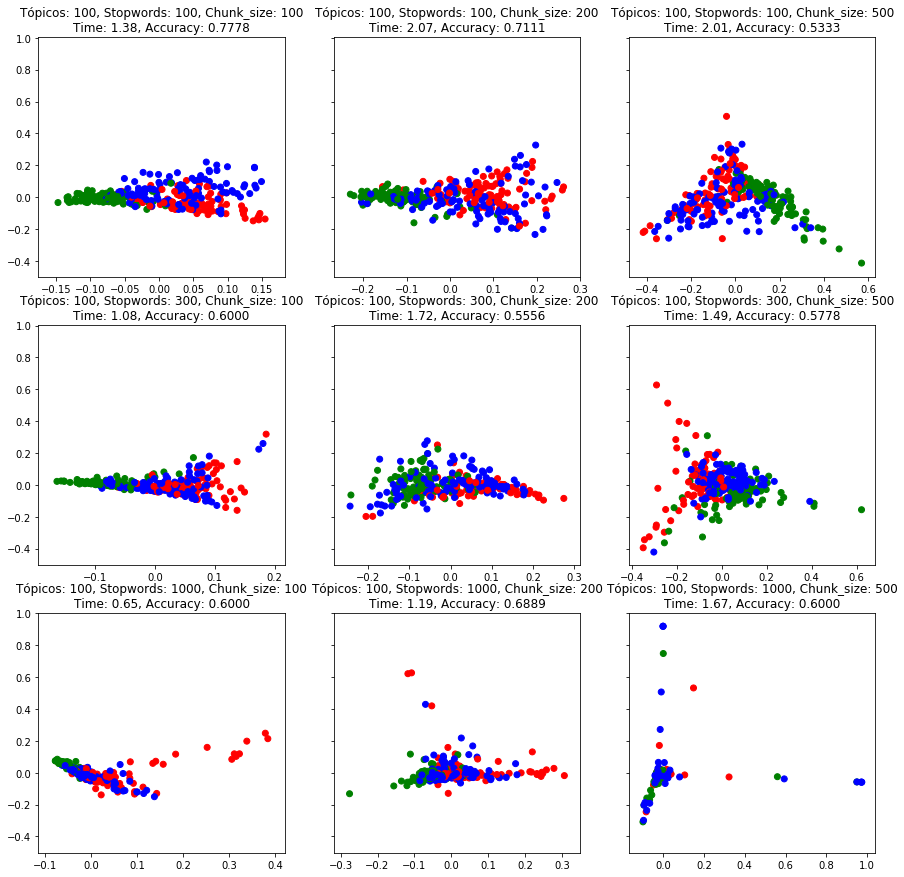

In [118]:
run_experiments(train_txts_spa, test_txts_spa, train_labels_spa, test_labels_spa,
                dictionary_spa, frecs_spa,
                n_topics = 100
               )

/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  di

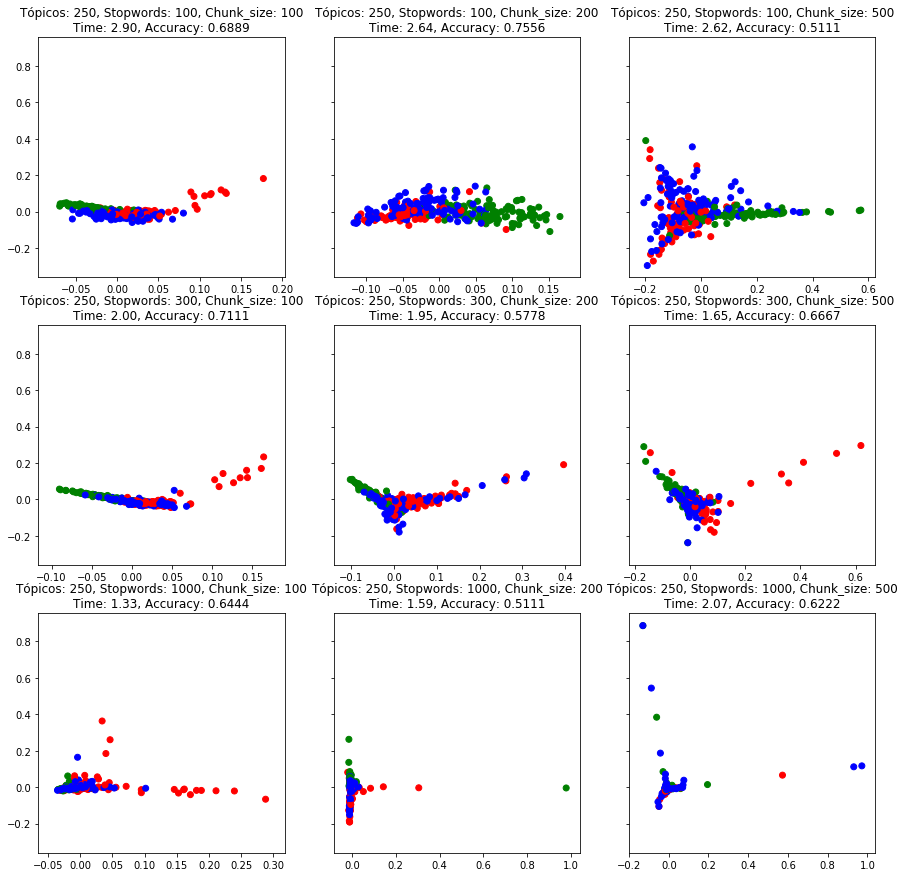

In [119]:
run_experiments(train_txts_spa, test_txts_spa, train_labels_spa, test_labels_spa,
                dictionary_spa, frecs_spa,
                n_topics = 250
               )

# Obteniendo clasificadores para las 3 lenguas

Tras observar los resultados anteriores, el mejor desempeño lo logró el modelo de 100 tópicos, con 100 stopwords y con un chunk_size de 100. Debido a esto, ahora entrenaré modelos en las 3 lenguas usando esos parámetros, pero dando mayor número de passes (15).

In [9]:
def get_model_and_classifier(train_txts, test_txts, train_labels, test_labels,
                             dictionary, frecs, n_topics, n_stw, chunk_size,
                             overlap_size, passes = 3, iterations = 400):
    
    txts_colors = myutils.index2color(train_labels + test_labels, ['red', 'green', 'blue'])

    inicio = time.time()
    
    model = train_model(train_txts, dictionary, frecs, n_topics = n_topics, n_stw = n_stw,
                        chunk_size = chunk_size, overlap_size = overlap_size, passes = passes, iterations = iterations)

    X_train = transform_documents(train_txts, dictionary, frecs, model = model, n_topics = n_topics, n_stw = n_stw)
    X_test = transform_documents(test_txts, dictionary, frecs, model = model, n_topics = n_topics, n_stw = n_stw)

    clf = RandomForestClassifier()
    clf.fit(X_train, train_labels)
    accuracy = clf.score(X_test, test_labels)
    
    pca = PCA(n_components=2)
    embeddings2D = pca.fit_transform(np.vstack([X_train, X_test]))
    
    ellapsed = (time.time() - inicio)/60
    
    titulo = "Tópicos: {0}, Stopwords: {1}, Chunk_size: {2}\nTime: {3}, Accuracy:{4}"\
        .format(n_topics, n_stw, chunk_size, ellapsed, accuracy)
    
    myutils.plot_data(embeddings2D, colores = txts_colors, titulo = titulo)
    
    return model, clf

/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


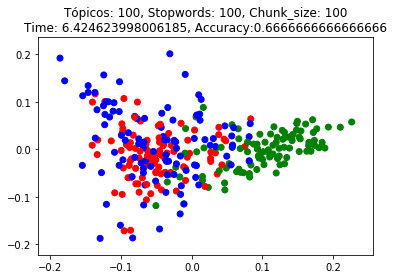

In [11]:
model_spa, clf_spa = get_model_and_classifier(train_txts_spa, test_txts_spa, train_labels_spa, test_labels_spa,
                             dictionary_spa, frecs_spa, n_topics = 100, n_stw = 100, chunk_size = 100,
                             overlap_size = 50, passes = 15, iterations = 400)

In [15]:
model_spa.show_topics()

[(36,
  '0.099*"nueva" + 0.083*"york" + 0.072*"boda" + 0.062*"alex" + 0.053*"leer" + 0.027*"soltero" + 0.025*"sótano" + 0.023*"correo" + 0.023*"américa" + 0.021*"director"'),
 (5,
  '0.098*"bob" + 0.039*"arrepentir" + 0.036*"gira" + 0.032*"humor" + 0.030*"roma" + 0.023*"organizar" + 0.021*"valle" + 0.021*"francés" + 0.019*"ahorrar" + 0.018*"inesperado"'),
 (25,
  '0.040*"hermano" + 0.027*"amigo" + 0.018*"bello" + 0.016*"también" + 0.016*"chico" + 0.012*"prometer" + 0.012*"preocupar" + 0.011*"problema" + 0.011*"divertir" + 0.010*"tomar"'),
 (22,
  '0.031*"jugar" + 0.029*"derecho" + 0.021*"eric" + 0.020*"calvin" + 0.020*"abogado" + 0.020*"mono" + 0.019*"bola" + 0.018*"entender" + 0.017*"pena" + 0.015*"escuchar"'),
 (28,
  '0.025*"año" + 0.016*"semana" + 0.014*"porque" + 0.011*"gustar" + 0.010*"relación" + 0.010*"día" + 0.010*"tan" + 0.010*"trabajo" + 0.009*"conocer" + 0.009*"parecer"'),
 (2,
  '0.106*"sueño" + 0.050*"canción" + 0.039*"soñar" + 0.038*"cantar" + 0.038*"despertar" + 0.018*"

/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


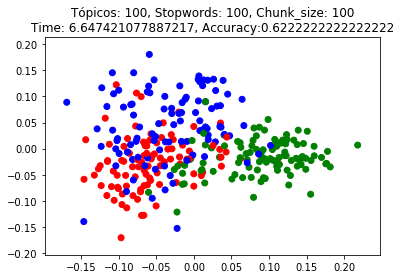

In [16]:
model_eng, clf_eng = get_model_and_classifier(train_txts_eng, test_txts_eng, train_labels_eng, test_labels_eng,
                             dictionary_eng, frecs_eng, n_topics = 100, n_stw = 100, chunk_size = 100,
                             overlap_size = 50, passes = 15, iterations = 400)

In [18]:
model_eng.show_topics()

[(58,
  '0.073*"beauty" + 0.072*"chair" + 0.043*"television" + 0.037*"los" + 0.033*"honk" + 0.032*"statement" + 0.032*"angeles" + 0.031*"da" + 0.029*"senior" + 0.029*"occasion"'),
 (46,
  '0.077*"call" + 0.054*"police" + 0.052*"key" + 0.044*"phone" + 0.035*"street" + 0.034*"cop" + 0.019*"officer" + 0.018*"building" + 0.015*"apartment" + 0.015*"voice"'),
 (31,
  '0.111*"book" + 0.071*"write" + 0.051*"guy" + 0.046*"mama" + 0.036*"picture" + 0.026*"show" + 0.024*"play" + 0.024*"story" + 0.017*"suck" + 0.017*"fun"'),
 (90,
  '0.052*"jamie" + 0.046*"proof" + 0.043*"sally" + 0.041*"theory" + 0.036*"ill" + 0.026*"dozen" + 0.025*"trial" + 0.025*"girlfriend" + 0.025*"visitor" + 0.020*"depth"'),
 (47,
  '0.073*"evil" + 0.037*"rat" + 0.035*"duty" + 0.034*"st" + 0.025*"al" + 0.024*"league" + 0.021*"discover" + 0.021*"horizon" + 0.019*"men" + 0.019*"branch"'),
 (52,
  '0.083*"james" + 0.065*"pant" + 0.044*"romantic" + 0.042*"bond" + 0.034*"clay" + 0.030*"snow" + 0.028*"pipe" + 0.026*"ding" + 0.022*

/home/antoniovs/Escolar/Sem09/anal-txts/proyecto2/environment/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


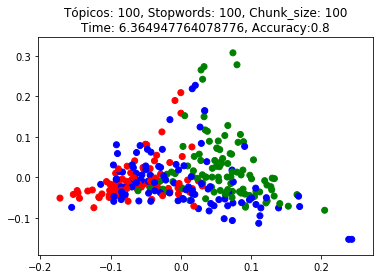

In [19]:
model_fre, clf_fre = get_model_and_classifier(train_txts_fre, test_txts_fre, train_labels_fre, test_labels_fre,
                             dictionary_fre, frecs_fre, n_topics = 100, n_stw = 100, chunk_size = 100,
                             overlap_size = 50, passes = 15, iterations = 400)

In [20]:
model_fre.show_topics()

[(29,
  '0.034*"copain" + 0.031*"adorer" + 0.030*"jouer" + 0.028*"joue" + 0.023*"super" + 0.019*"accompagner" + 0.018*"adorable" + 0.018*"salut" + 0.016*"jean" + 0.016*"logan"'),
 (91,
  '0.036*"dieu" + 0.032*"éternel" + 0.031*"bobby" + 0.029*"ie" + 0.026*"ia" + 0.026*"prêtre" + 0.021*"siècle" + 0.020*"phénomène" + 0.018*"race" + 0.018*"mark"'),
 (25,
  '0.061*"pierre" + 0.033*"célibataire" + 0.025*"rituel" + 0.024*"choc" + 0.024*"brave" + 0.022*"adulte" + 0.022*"sec" + 0.019*"parfum" + 0.018*"juif" + 0.018*"ballon"'),
 (71,
  '0.049*"entendre" + 0.037*"recevoir" + 0.029*"dieu" + 0.028*"tirer" + 0.026*"signal" + 0.025*"allumer" + 0.024*"vite" + 0.022*"bruit" + 0.021*"tour" + 0.019*"accrocher"'),
 (87,
  '0.145*"film" + 0.062*"scène" + 0.033*"acteur" + 0.025*"goût" + 0.024*"rire" + 0.023*"chemise" + 0.023*"viande" + 0.022*"adorer" + 0.021*"edward" + 0.017*"cinéma"'),
 (73,
  '0.072*"mordre" + 0.064*"end" + 0.062*"week" + 0.049*"toilette" + 0.028*"jambe" + 0.027*"daniel" + 0.024*"billet"

In [22]:
model_spa.save("./pickles/modelos/model_spa.model")
model_eng.save("./pickles/modelos/model_eng.model")
model_fre.save("./pickles/modelos/model_fre.model")

# Conclusiones y trabajo futuro
- A decir verdad los resultados de los experimentos con los parámetros me sorprendieron, ya que yo esperaba que 100 stopwords fueran muy pocas y que ello causara ruido en el minado de tópicos. Sin embargo, sucedió que el modelo con mejor desempeño fue entrenado con 100 stopwords.
- En general encuentro algo difícil de interpretar las gráficas de los resultados. Pero creo que es seguro decir que el chunk_size determina la forma de la distribución de los datos, mientras que el número de stopwords define la varianza. A mayor stopwords menor varianza, y los documentos tienden a concentrarse en las mismas regiones. No termino de descifrar esto, ya que yo esperaba que a mayor stopwords, menos fueran las palabras en común entre documentos, y eso obligara a tener tópicos más diferenciados, que a su vez hicieran a los documentos más separados.
- Por su parte, también me llevé una sorpresa con los resultados del modelado de tópicos con los 3 idiomas. Esperaba que tuvieran el mismo desempeño, y sin embargo el Francés tuvo mucho mejores resultados que los otros. Además, otra sorpresa, es que aunque subí el número de passes, el desempeño en español fue menor que el desempeño en la fase de elección de parámetros.
- Además, no sé bien cómo interpretar la varianza en los resultados del desempeño. Sucede que aunque uno corra un experimento con los mismos parámetros, el desempeño suele variar. Esto hace aún más difícil de interpretar los resultados y decir bien a bien dónde se podrían hacer mejoras.
- En general supongo que lo que se podría hacer es, justamente, correr más experimentos, obtener más métricas, variar cosas que dejé fijas, aumentar el número de passes e iteraciones en la fase de elección de parámetros, e incluso utilizar otro clasificador distintos a Random Forests.